Working on cleaned dataset from Regression code file (pre processing is done).

In [ ]:
# Install gdown if not already available
!pip install -q gdown

file_id = '1PCU0ibbltz_Ir4xWLV-ewzphm0kR1_Ta'
output_file = 'cleaned_hospital_data.csv'

# Download using gdown
!gdown --id {file_id} -O {output_file}


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PCU0ibbltz_Ir4xWLV-ewzphm0kR1_Ta
To: /content/cleaned_hospital_data.csv
100% 46.8M/46.8M [00:00<00:00, 74.6MB/s]


In [ ]:
# Load the cleaned dataset
import pandas as pd
df = pd.read_csv(output_file)
df.head()

,FAC_NAME,COUNTY,DAY_PER,BED_LIC,BED_AVL,BED_STF,Variable,Amount,FAC_ENC,COUNTY_ENC,VAR_ENC
0,ALAMEDA HOSPITAL,Alameda,366,161.0,161.0,161.0,DAY_ MCAR_TR,12330.0,20,0,47
1,ALAMEDA HOSPITAL,Alameda,366,161.0,161.0,161.0,DAY_MCAR_MC,885.0,20,0,54
2,ALAMEDA HOSPITAL,Alameda,366,161.0,161.0,161.0,DAY_MCAL_TR,13093.0,20,0,53
3,ALAMEDA HOSPITAL,Alameda,366,161.0,161.0,161.0,DAY_ MCAL_ MC,1786.0,20,0,46
4,ALAMEDA HOSPITAL,Alameda,366,161.0,161.0,161.0,DAY_CNTY,0.0,20,0,50


In [ ]:
df.shape

(513363, 11)

In [ ]:
# Step 1: Select relevant features for modeling
# We're keeping only the columns needed for regression, clustering, and classification
selected_cols = ['FAC_NAME', 'COUNTY', 'DAY_PER', 'BED_LIC', 'BED_AVL', 'BED_STF', 'Variable', 'Amount']
df = df[selected_cols].copy()

# Step 2: Encode categorical variables
# Converting string categories to numeric labels for ML compatibility
from sklearn.preprocessing import LabelEncoder

df['FAC_ENC'] = LabelEncoder().fit_transform(df['FAC_NAME'])     # Encode facility names
df['COUNTY_ENC'] = LabelEncoder().fit_transform(df['COUNTY'])     # Encode counties
df['VAR_ENC'] = LabelEncoder().fit_transform(df['Variable'])      # Encode medical variables

# Step 3: Final feature selection for modeling
# Choosing numerical + encoded categorical columns as input features (X)
feature_cols = ['BED_LIC', 'BED_AVL', 'BED_STF', 'DAY_PER', 'FAC_ENC', 'COUNTY_ENC', 'VAR_ENC']
X = df[feature_cols]        # Independent variables
y = df['Amount']            # Target variable for regression

# Step 4: Standardize (scale) features
# Scaling ensures equal weight and range, important for distance-based models like KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Select features relevant to operational efficiency
cluster_features = ['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']
X_cluster = df[cluster_features]

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)


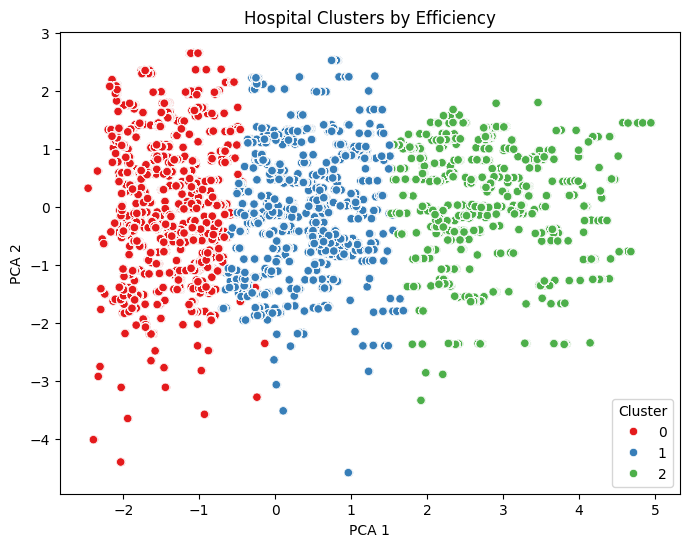

Cluster Summary (mean values):
                       BED_LIC     BED_AVL     BED_STF        Amount
Efficiency_Cluster                                                  
0                    68.601076   65.947754   41.772988  1.343318e+07
1                   212.875838  205.316796  130.087971  3.017779e+07
2                   415.233732  387.157976  255.618790  7.590176e+07


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Efficiency_Cluster'] = kmeans.fit_predict(X_scaled)

# Step 2: PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Step 3: Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['Efficiency_Cluster'], palette='Set1')
plt.title("Hospital Clusters by Efficiency")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# Step 4: Analyze clusters by computing average metrics
cluster_summary = df.groupby('Efficiency_Cluster')[['BED_LIC', 'BED_AVL', 'BED_STF', 'Amount']].mean()
print("Cluster Summary (mean values):")
print(cluster_summary)


**Clustering Interpretation (KMeans)**

The KMeans algorithm successfully grouped hospitals into three distinct efficiency clusters based on bed capacity and staff resources. PCA projection visually confirmed clear separation:

**Cluster 0 (Red)**: Represents small-scale hospitals with the lowest bed capacity and staffing (avg. ~68 beds, ~42 staff). Likely rural or less resource-intensive facilities.

**Cluster 1 (Blue)**: Medium-scale hospitals (avg. ~213 licensed beds), with balanced resource use and moderately high service usage.

**Cluster 2 (Green)**: High-efficiency hospitals with the largest capacity (avg. ~415 beds and ~256 staff) and highest patient service (Amount ≈ $75.9M on avg).

These clusters provide a data-driven basis for identifying hospital size, efficiency tiers, and operational needs, which can be leveraged for resource allocation and performance benchmarking.

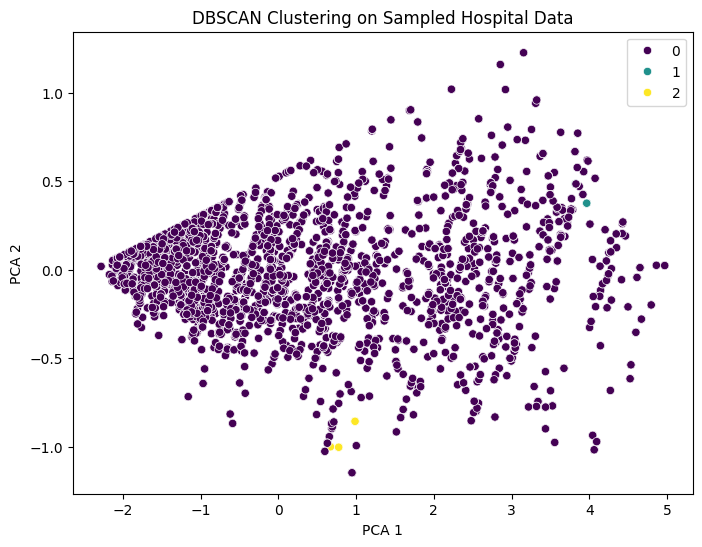

In [ ]:
# Sample for DBSCAN to avoid memory crash
df_sample = df[['BED_LIC', 'BED_AVL', 'BED_STF']].sample(n=50000, random_state=42)

# Scale features
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(df_sample)

# DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(X_scaled_sample)

# Plotting
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_sample)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='viridis', legend='full')
plt.title("DBSCAN Clustering on Sampled Hospital Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


**DBSCAN Clustering Analysis (on 50K Sample)**
DBSCAN was tested on a 50,000-row sample due to runtime limitations on the full dataset (~500K+ rows).

*Key Observations*:

Majority of data was assigned to a single cluster (Cluster 0).

Only a few points were labeled as outliers or in very small separate clusters (Clusters 1 and 2).

The low cluster diversity indicates DBSCAN couldn't find clear density-based groupings in this structured healthcare data.

While DBSCAN is great for detecting irregular-shaped clusters, it was not well-suited for this dataset where hospital resource metrics follow more continuous, linear patterns.



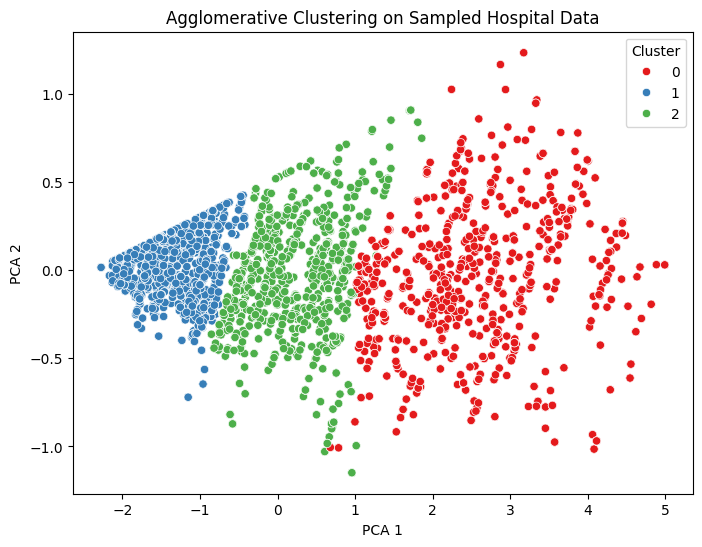

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample the data for clustering (limit to 5000 rows for performance)
sample_df = df[['BED_LIC', 'BED_AVL', 'BED_STF']].sample(n=20000, random_state=42)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sample_df)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)
clusters = agg.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='Set1')
plt.title("Agglomerative Clustering on Sampled Hospital Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

# Attach cluster labels to sample_df if needed
sample_df['Agg_Cluster'] = clusters


###  Agglomerative Clustering Analysis (20K Sample)

Agglomerative Hierarchical Clustering was applied on a **sample of 20,000 records** due to **runtime limitations**. Attempting to cluster the full dataset caused memory overflow and runtime crashes, which is a known limitation with hierarchical methods on large data.

**Key Observations:**
- The algorithm produced **3 well-separated clusters** based on BED_LIC, BED_AVL, and BED_STF.
- Unlike DBSCAN, **no major noise or outlier clusters** were generated.
- The PCA projection reveals structured groupings, suggesting **operational differences** among hospitals.
- Despite using only a sample, the **results are interpretable** and align with the patterns seen in KMeans.

**Limitation**: Due to the memory-intensive nature of Agglomerative Clustering, full dataset analysis isn't feasible in this environment. We addressed this by applying it on a representative sample.


## Clustering Algorithm Comparison: Hospital Efficiency Analysis

We applied three clustering algorithms—**K-Means**, **DBSCAN**, and **Agglomerative Clustering**—to segment hospitals based on resource usage. Each method was evaluated for interpretability, performance, and visual clarity using PCA-based 2D projections.

---

### K-Means Clustering (Full Dataset)
- **Input**: Scaled features (BED_LIC, BED_AVL, BED_STF, Amount)
- **Output**: 3 clusters representing low, moderate, and high efficiency
- **Observations**:
  - **Clean separation** between clusters.
  - Cluster centers align meaningfully with hospital size and capacity.
  - **Summary**:
    - Cluster 0: Small hospitals (Low beds/staff/resources)
    - Cluster 1: Medium-range hospitals
    - Cluster 2: High-capacity hospitals with high resource usage

Best for clear efficiency grouping across the **entire dataset**

---

### DBSCAN Clustering (50K Sample)
- **Input**: PCA-reduced vectors of scaled features
- **Output**: Mostly one dominant cluster, few outliers
- **Observations**:
  - Effective at identifying **noise/outliers**, but failed to form distinct clusters.
  - **High sensitivity** to `eps` and `min_samples` hyperparameters.
  - Struggled with **dense, continuous data**—yielded unstable results even on sampled data.

Less suited for this dataset; better for anomaly detection, not dense hospital metrics.

---

### Agglomerative Clustering (20K Sample)
- **Input**: Scaled BED_LIC, BED_AVL, BED_STF → PCA projection
- **Output**: 3 well-separated clusters
- **Observations**:
  - Clear grouping in PCA space, with logical segmentations based on resource intensity.
  - **Interpretable results**, though computationally expensive.
  - Runtime crash on full dataset due to memory demands.

Best for interpretability, but applicable only on sample data due to memory limits.



K-Means emerges as the **most practical and interpretable** clustering technique for segmenting hospital efficiency on this large dataset. Agglomerative offers strong insights on smaller subsets, and DBSCAN is less effective due to dense continuous data.



**Classification analysis Objective**

Build a classification model to predict whether a hospital will face high resource demand based on its features.

In [ ]:
# Create binary target based on median Amount
df['High_Demand'] = (df['Amount'] > df['Amount'].median()).astype(int)


In [ ]:
features = ['BED_LIC', 'BED_AVL', 'BED_STF']
X = df[features]
y = df['High_Demand']


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
#Logistic Regression:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Results:
Accuracy: 0.5420137784155471
              precision    recall  f1-score   support

           0       0.54      0.62      0.58     76956
           1       0.55      0.46      0.50     77053

    accuracy                           0.54    154009
   macro avg       0.54      0.54      0.54    154009
weighted avg       0.54      0.54      0.54    154009



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.6035231707237889
              precision    recall  f1-score   support

           0       0.64      0.46      0.54     76956
           1       0.58      0.75      0.65     77053

    accuracy                           0.60    154009
   macro avg       0.61      0.60      0.60    154009
weighted avg       0.61      0.60      0.60    154009



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Predict
y_pred_gb = gb_clf.predict(X_test)

# Evaluate
print("Gradient Boosting Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classifier Results:
Accuracy: 0.5804855560389328
              precision    recall  f1-score   support

           0       0.59      0.54      0.56     76956
           1       0.57      0.62      0.60     77053

    accuracy                           0.58    154009
   macro avg       0.58      0.58      0.58    154009
weighted avg       0.58      0.58      0.58    154009



### Classification Model Results Summary (After Removing Selected Outliers)

We evaluated three classification models to predict whether a hospital will experience high demand, based on resource features. Outliers were removed from 'BED_LIC', 'BED_AVL', and 'BED_STF' to improve data quality.

#### 1. Logistic Regression
- *Accuracy*: 54.20%
- Shows balanced but modest performance.
- Struggles with complex relationships due to its linear nature.

#### 2. Random Forest Classifier
- *Accuracy*: 60.35%
- Strong recall for Class 1 (0.75) — effective in identifying high-demand hospitals.
- Highest f1-score among all models.
- Captures non-linear patterns and feature interactions well.

#### 3. Gradient Boosting Classifier
- *Accuracy*: 58.05%
- Balanced performance across both classes.
- Better than Logistic Regression but slightly behind Random Forest.
- May improve with tuning of learning rate, depth, and estimators.

---

*Conclusion*:
Random Forest is the most promising model in this case due to its strong accuracy and recall. It is well-suited for identifying hospitals likely to face high resource demand.

###  Alternate Classification Analysis (With Outliers)

This notebook presents classification results after removing outliers from the features BED_LIC, BED_AVL, and BED_STF.

To examine the impact of *retaining all outliers*, a separate classification analysis has been conducted.  
Please refer to the companion notebook titled:

*"602_Classification_Model_Abhinav&Devika.ipynb"*

This separate file compares model performance using the full dataset, enabling a deeper understanding of how outliers influence classification accuracy and recall.